# Dataset 1 - Regression

## Experiment Details 

The aim of the experiment is to verify if the:
1. ABC_GAN model corrects model misspecification
2. ABC_GAN model performs better and converges faster than a simple C-GAN model

In the experiment we predict the distribution that represents the real data and simulate realistic fake data points
using statistical mode, C-GAN and ABC-GAN model with 3 priors. We analyze and compare their performance using metrics like mean squared error, mean absolute error , manhattan distance and euclidean distance between $y_{real}$ and $y_{pred}$

The models are as follows:

1. The statistical model assumes the distribution $Y=\beta X + \mu$ where $\mu \sim N(0,1)$
2. The Conditional GAN consists of
    1. Generator with 2 hidden layers with 100 nodes each and ReLu activation.
    2. Discriminator with 2 hidden layers with 25 and 50 nodes and ReLu activation. 
    We use Adam's optimser and BCE to train the model. The input to the Generator of the GAN is (x,e) where x are the features and $e \sim N(0,1)$. The discriminator output is sigmoid. 
3. The ABC GAN Model consists of 
    1. ABC generator is defined as follows:
        1. $Y = 1 + \beta_1 x_1 + \beta_2 x_2 + \beta_2 x_3 + ... + \beta_n x_n + N(0,\sigma)$ where $\sigma = 0.1$ 
        2. $\beta_i \sim N(0,\sigma^{*})$ when $\mu = 0$ else $\beta_i \sim N(\beta_i^{*},\sigma^{*})$ where $\beta_i^{*}s$ are coefficients obtained from statistical model
        3. $\sigma^{*}$ takes the values 0.01,0.1 and 1      
    2. C-GAN network is as defined above. However the input to the Generator of the GAN is $(x,y_{abc})$ where $y_{abc}$ is the output of the ABC Generator.
        

## Import Libraries 

In [1]:
import warnings
import sys
sys.path.insert(0, '../src')
warnings.filterwarnings('ignore')

In [2]:
import train_test
import ABC_train_test
import regressionDataset
import network
import statsModel
import performanceMetrics
import dataset
import sanityChecks
import torch 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import norm
from torch.utils.data import Dataset,DataLoader 
from torch import nn

## Parameters

General Parameters 

1. Number of Samples
2. Number of features 

ABC-Generator parameters are as mentioned below: 
1. mean : 1 ($\beta \sim N(\beta^{*},\sigma)$ where $\beta^{*}$ are coefficients of statistical model) or 1 ($\beta \sim N(0,\sigma)$
2. std : $\sigma = 1, 0.1 , 0.01$ (standard deviation)

In [3]:
n_features = 10
n_samples= 100
 
#ABC Generator Parameters
mean = 1 
variance = 0.001

## Dataset

Generate a random regression problem

$Y = 1 + \beta_1 x_1 + \beta_2 x_2 + \beta_2 x_3 + ... + \beta_n x_n + N(0,\sigma)$ where $\sigma = 0.1$

In [4]:
X,Y = regressionDataset.regression_data(n_samples,n_features)

         X1        X2        X3        X4        X5        X6        X7  \
0  0.475814 -0.428622  0.291575 -0.147059 -0.187427 -0.208793  0.721863   
1  0.616470  0.781976  0.645824  0.625500  1.306707 -1.344367  1.449941   
2 -0.323855  0.284677  0.514990  1.009846  0.812349 -1.324009 -0.309025   
3 -1.132682  0.407354 -1.191597  0.358099  1.321929  0.522000  0.287731   
4 -0.611326 -0.158276 -0.247776  0.163173 -1.000225  0.278988 -0.260845   

         X8        X9       X10           Y  
0  1.349776  0.801684 -1.762175  -40.143718  
1 -1.094116  0.890335  0.043090    5.234960  
2  0.111174  0.269986 -1.651083 -123.509954  
3  0.080127  0.374205 -0.309284  -47.632381  
4  1.926239  0.511005 -0.851832    0.803686  


## Stats Model

No handles with labels found to put in legend.


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.260e+07
Date:                Wed, 10 Nov 2021   Prob (F-statistic):          1.98e-280
Time:                        12:17:16   Log-Likelihood:                 595.48
No. Observations:                 100   AIC:                            -1169.
Df Residuals:                      89   BIC:                            -1140.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.327e-17   6.65e-05   1.25e-12      1.0

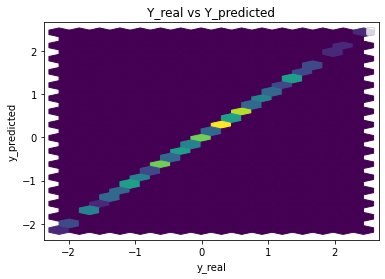

Performance Metrics
Mean Squared Error: 3.9378883669505273e-07
Mean Absolute Error: 0.0005173784198430987
Manhattan distance: 0.05173784198430988
Euclidean distance: 0.006275259649568716


In [5]:
[coeff,y_pred] = statsModel.statsModel(X,Y)

## Common Training Parameters (GAN & ABC_GAN) 

In [6]:
n_epochs = 5000
error = 0.001
batch_size = n_samples

## GAN Model

In [7]:
real_dataset = dataset.CustomDataset(X,Y)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Training GAN for n_epochs number of epochs** 

In [8]:
generator = network.Generator(n_features+2)
discriminator = network.Discriminator(n_features+2)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(generator.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=0.01, betas=(0.5, 0.999))

In [9]:
print(generator)
print(discriminator)

Generator(
  (hidden1): Linear(in_features=12, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)
Discriminator(
  (hidden1): Linear(in_features=12, out_features=25, bias=True)
  (hidden2): Linear(in_features=25, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [10]:
discLossG1,genLossG1 = train_test.training_GAN(discriminator,generator,disc_opt,gen_opt,real_dataset,batch_size, n_epochs,criterion,device)

In [11]:
GAN1_metrics = train_test.test_generator(generator,real_dataset,device)

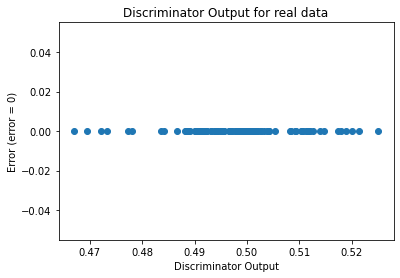

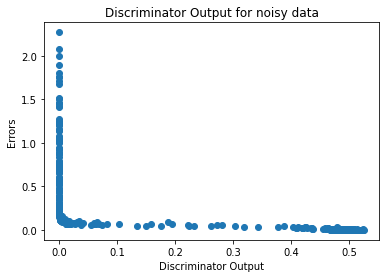

In [12]:
sanityChecks.discProbVsError(real_dataset,discriminator,device)

**Training GAN until mse of y_pred is > 0.1 or n_epochs < 30000**

In [13]:
generator2 = network.Generator(n_features+2)
discriminator2 = network.Discriminator(n_features+2)
criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(generator2.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator2.parameters(), lr=0.01, betas=(0.5, 0.999))

In [14]:
discLossG2,genLossG2 =train_test.training_GAN_2(discriminator2,generator2,disc_opt,gen_opt,real_dataset,batch_size,error,criterion,device)

Number of epochs needed 644


In [15]:
GAN2_metrics=train_test.test_generator_2(generator2,real_dataset,device)

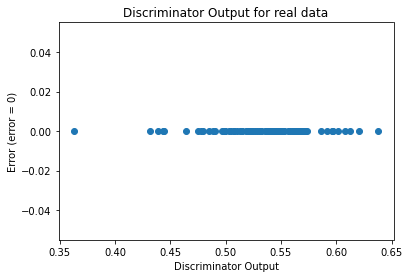

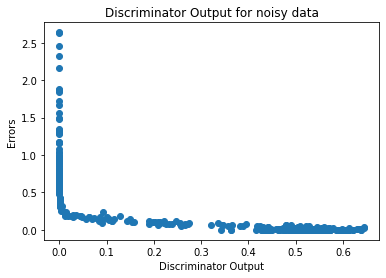

In [16]:
sanityChecks.discProbVsError(real_dataset,discriminator2,device)

# ABC GAN Model

### Training the network
**Training ABC-GAN for n_epochs number of epochs** 

In [17]:
gen = network.Generator(n_features+2)
disc = network.Discriminator(n_features+2)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

In [18]:
discLossA1,genLossA1 = ABC_train_test.training_GAN(disc, gen,disc_opt,gen_opt,real_dataset, batch_size, n_epochs,criterion,coeff,mean,variance,device)

In [25]:
ABC_GAN1_metrics=ABC_train_test.test_generator(gen,real_dataset,coeff,mean,variance,device)

#### Sanity Checks 

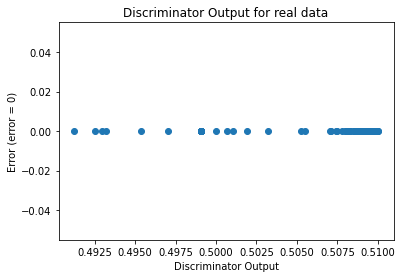

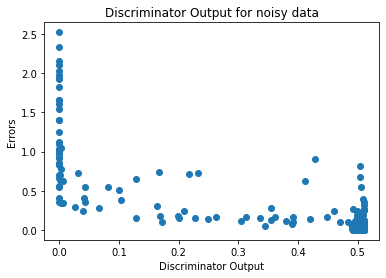

In [26]:
sanityChecks.discProbVsError(real_dataset,disc,device)

**Training GAN until mse of y_pred is > 0.1 or n_epochs < 30000**

In [20]:
gen2 = network.Generator(n_features+2)
disc2 = network.Discriminator(n_features+2)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen2.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc2.parameters(), lr=0.01, betas=(0.5, 0.999))

In [21]:
discLossA2,genLossA2 = ABC_train_test.training_GAN_2(disc2,gen2,disc_opt,gen_opt,real_dataset,batch_size, error,criterion,coeff,mean,variance,device)

Number of epochs 336


In [22]:
ABC_GAN2_metrics=ABC_train_test.test_generator_2(gen2,real_dataset,coeff,mean,variance,device)

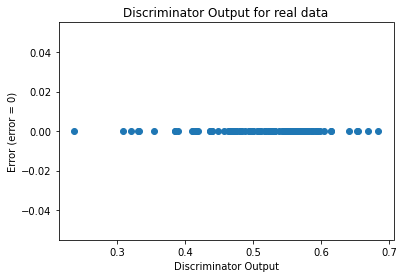

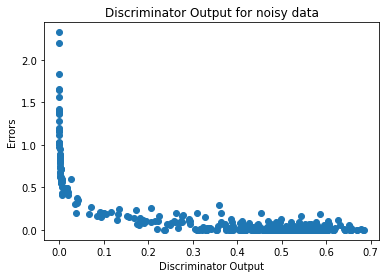

In [23]:
sanityChecks.discProbVsError(real_dataset,disc2,device)

# Model Analysis

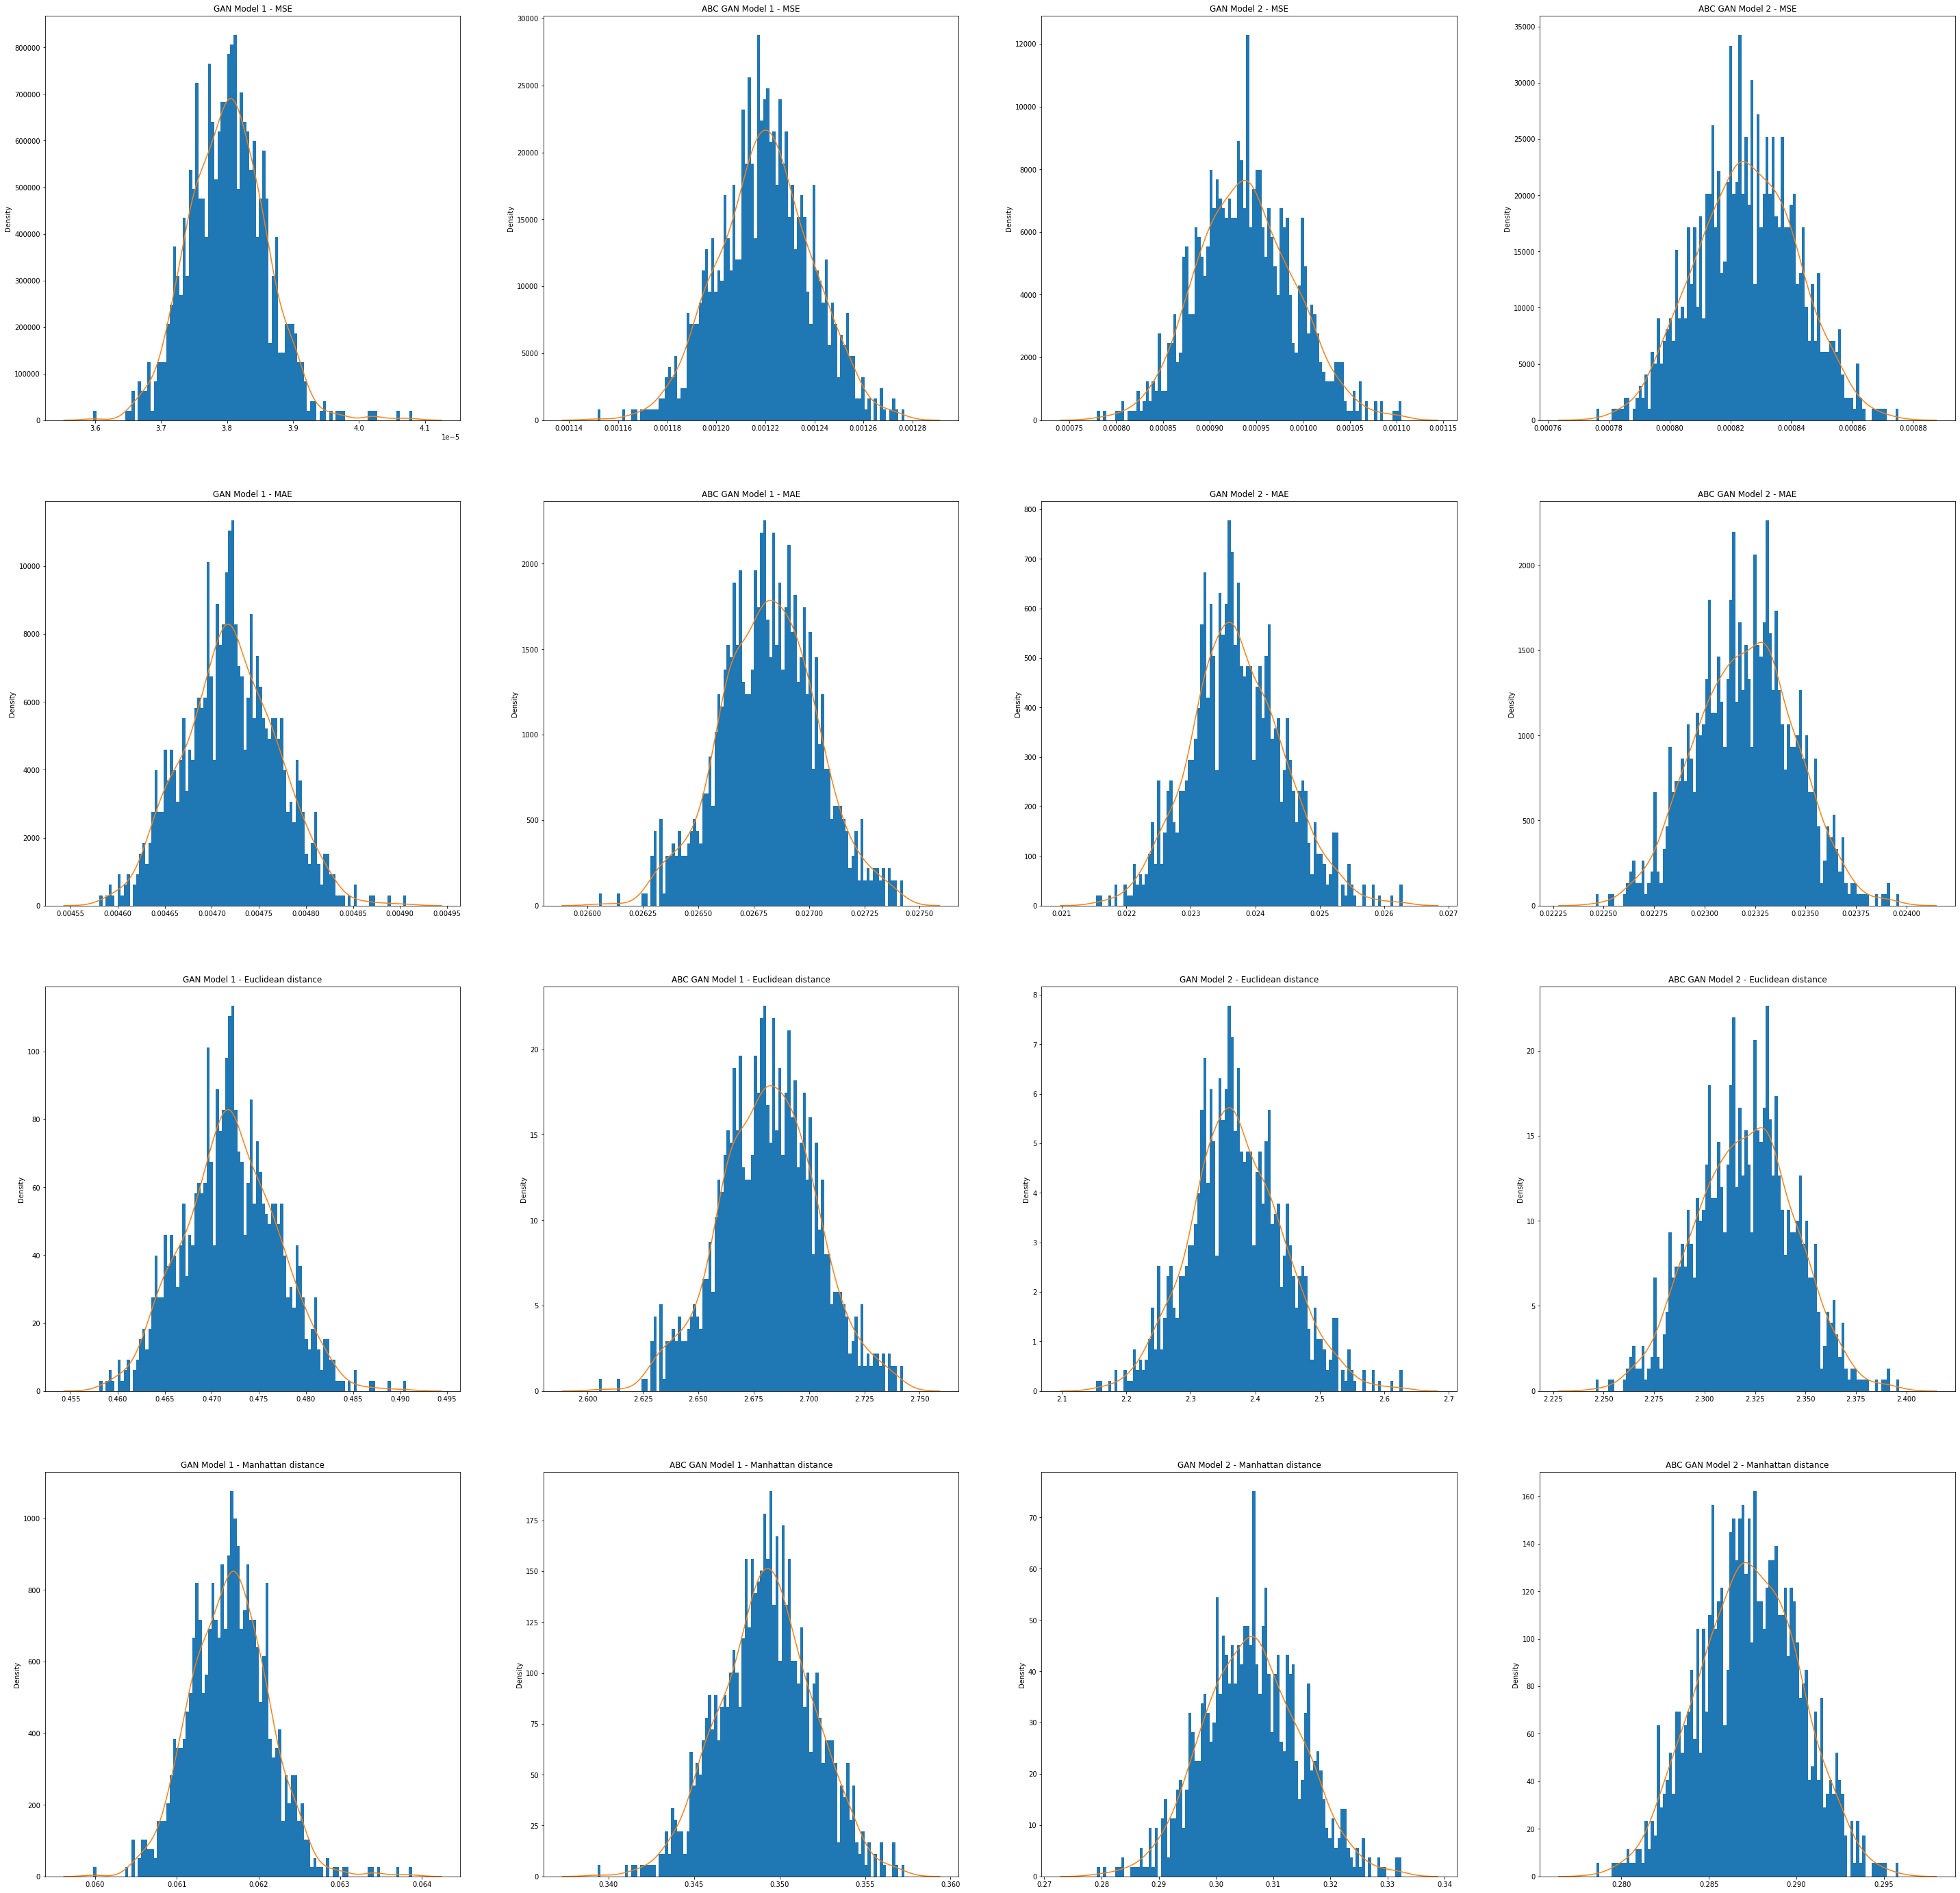

In [27]:
performanceMetrics.modelAnalysis(GAN1_metrics,ABC_GAN1_metrics,GAN2_metrics,ABC_GAN2_metrics)

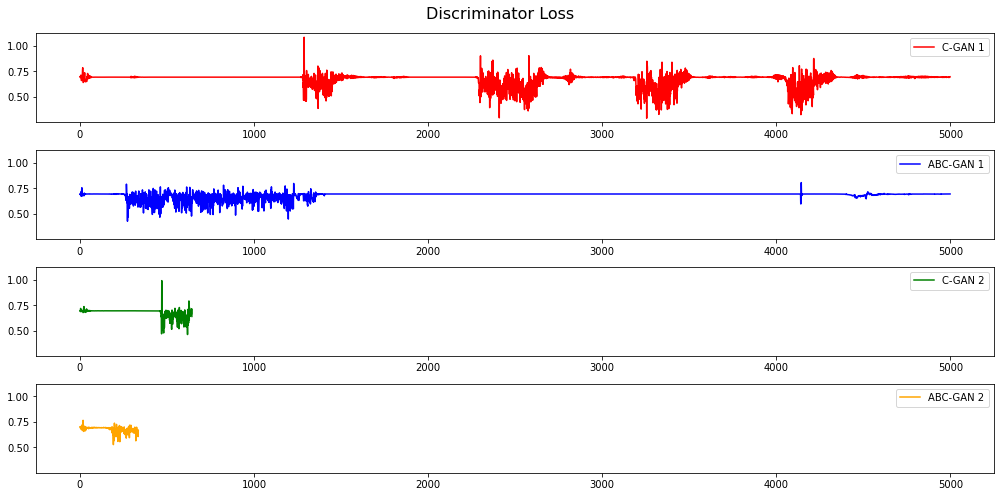

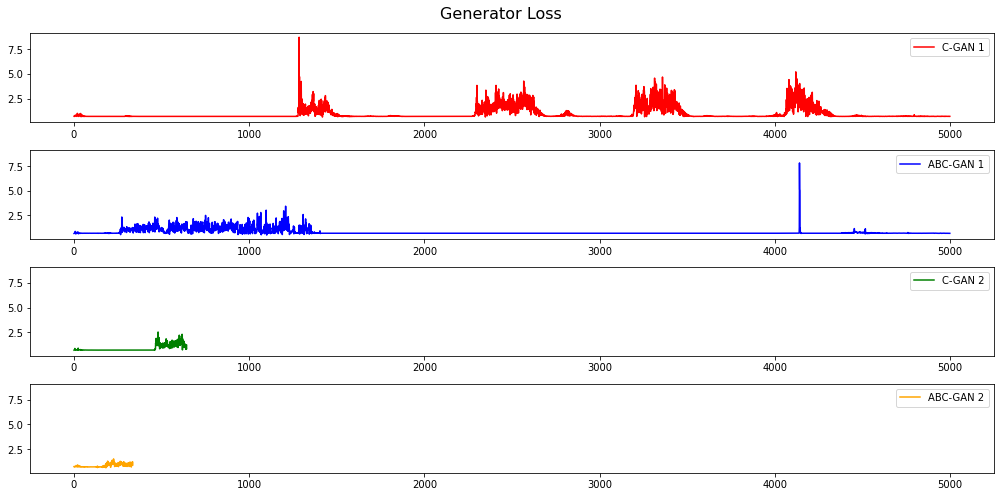

In [48]:
performanceMetrics.plotTrainingLoss(discLossG1,genLossG1,discLossA1,genLossA1,discLossG2,genLossG2,discLossA2,genLossA2)